In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#precision_score
from sklearn.metrics import precision_score
#recall_score
from sklearn.metrics import recall_score
#f1_score
from sklearn.metrics import f1_score
#support
from sklearn.metrics import classification_report

In [2]:
#data loading
df=pd.read_csv("creditcard.csv")

In [3]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

From the above output, this dataset is deeply imbalanced. In addition, with so many features, there are some hidden patterns that existing detection didn't capture. Therefore, it is necessary to relabel the dataset.

In [4]:
df['Time']

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [5]:
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24)

In [6]:
x=df.drop(["Class"],axis=1)
y=df['Class']

In [7]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

The above output is interest as it demonstrates that according to the existing data, there are so many transactions that should have been flagged

After relabelling, using festure engineering to select relevant features is paramount

### Correlation

<AxesSubplot:>

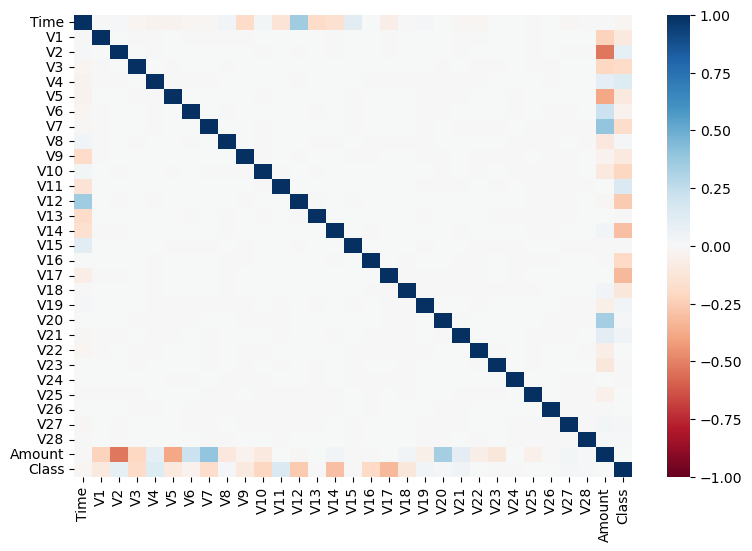

In [8]:
x_corr = df.drop(['Class'], axis=1)
corr = df.corr()
plt.figure(figsize=(9,6))
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax= 1)

In [9]:
correlation_matrix=df.corr()
corr_feature_lst=abs(correlation_matrix.iloc[:,-1]).sort_values(ascending=False)

In [10]:
corr_feature_lst

Class     1.000000
V17       0.326481
V14       0.302544
V12       0.260593
V10       0.216883
V16       0.196539
V3        0.192961
V7        0.187257
V11       0.154876
V4        0.133447
V18       0.111485
V1        0.101347
V9        0.097733
V5        0.094974
V2        0.091289
V6        0.043643
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
Time      0.017082
V28       0.009536
V24       0.007221
Amount    0.005632
V13       0.004570
V26       0.004455
V15       0.004223
V25       0.003308
V23       0.002685
V22       0.000805
Name: Class, dtype: float64

In [11]:
selected_10_features_from_corr=list(corr_feature_lst.index)[1:11]

In [12]:
selected_10_features_from_corr

['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18']

The above gives ranks on the importance of different features. However, correlation only indicates linear relationships.

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
ndf=df.copy()

In [15]:
x=ndf.drop("Class",axis=1)
y=ndf["Class"]

In [16]:
from pandas.core.common import random_state
rf=RandomForestClassifier(random_state=42)
rf.fit(x,y)

RandomForestClassifier(random_state=42)

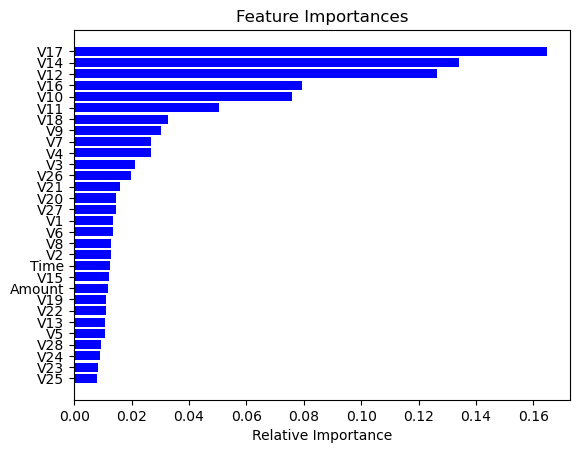

In [17]:
features = x.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [18]:
importances

array([0.01249799, 0.01364177, 0.01264662, 0.0211399 , 0.02658221,
       0.01058   , 0.01347176, 0.02678862, 0.01267019, 0.03031583,
       0.07586425, 0.05050917, 0.12647407, 0.01070423, 0.1342035 ,
       0.01227177, 0.07924507, 0.16459337, 0.03250608, 0.01106769,
       0.01448506, 0.01607105, 0.01097524, 0.0083937 , 0.00896313,
       0.0078794 , 0.01985935, 0.01446232, 0.00936567, 0.011771  ])

In [19]:
#select top 10 performed features as the features below tend to perform worse
selected_features_rf=x.columns[importances.argsort()[::-1][:10]].tolist()

In [20]:
selected_features_rf

['V17', 'V14', 'V12', 'V16', 'V10', 'V11', 'V18', 'V9', 'V7', 'V4']

Generally, the features revealed from Random Forest are more convincing as it takes linear and nonlinear relationship into consideration

### Train Model

For loop

In [24]:
from sklearn.model_selection import train_test_split

In [21]:
df_nonF = df[df['Class'] == 0]
df_F = df[df['Class'] == 1]

Logistic Regression

In [52]:
acc_lgr = []
precision_lgr = []
recall_lgr = []
f1_lgr = []
for i in range(100):
    df_sample = df_nonF.sample(n=492)
    df_input = pd.concat([df_sample, df_F])
    X = df_input.drop(['Class'], axis=1)
    y = df_input['Class']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    lgr = LogisticRegression(solver='liblinear')
    lgr.fit(x_train, y_train)
    y_pred = lgr.predict(x_test)
    acc_lgr.append(accuracy_score(y_test, y_pred))
    precision_lgr.append(precision_score(y_test, y_pred))
    recall_lgr.append(recall_score(y_test, y_pred))
    f1_lgr.append(f1_score(y_test, y_pred))

Random Forest

In [42]:
acc_rf = []
precision_rf = []
recall_rf = []
f1_rf = []

for i in range(100):
    df_sample = df_nonF.sample(n=492)
    df_input = pd.concat([df_sample, df_F])
    X = df_input.drop(['Class'], axis=1)
    y = df_input['Class']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    rf = RandomForestClassifier(random_state=42)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    acc_rf.append(accuracy_score(y_test, y_pred))
    precision_rf.append(precision_score(y_test, y_pred))
    recall_rf.append(recall_score(y_test, y_pred))
    f1_rf.append(f1_score(y_test, y_pred))

Xgboost

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight
#xgboost
from xgboost import XGBClassifier

In [48]:
acc_xgb = []
precision_xgb = []
recall_xgb = []
f1_xgb = []

for i in range(100):
    df_sample = df_nonF.sample(n=492)
    df_input = pd.concat([df_sample, df_F])
    X = df_input.drop(['Class'], axis=1)
    y = df_input['Class']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    xgb = XGBClassifier(objective='reg:squarederror', n_estimators=20, seed=123)
    xgb.fit(x_train, y_train)
    y_pred = xgb.predict(x_test)
    acc_xgb.append(accuracy_score(y_test, y_pred))
    precision_xgb.append(precision_score(y_test, y_pred))
    recall_xgb.append(recall_score(y_test, y_pred))
    f1_xgb.append(f1_score(y_test, y_pred))

Decision Tree

In [47]:
acc_dt = []
precision_dt = []
recall_dt = []
f1_dt = []

for i in range(100):
    df_sample = df_nonF.sample(n=492)
    df_input = pd.concat([df_sample, df_F])
    X = df_input.drop(['Class'], axis=1)
    y = df_input['Class']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=0.13, random_state=3)
    dt.fit(x_train, y_train)
    y_pred = dt.predict(x_test)
    acc_dt.append(accuracy_score(y_test, y_pred))
    precision_dt.append(precision_score(y_test, y_pred))
    recall_dt.append(recall_score(y_test, y_pred))
    f1_dt.append(f1_score(y_test, y_pred))
    

In [ ]:
acc = pd.DataFrame(acc_lgr, columns=['Logistic Regression'])
acc['Random Forest'] = acc_rf
acc['XGBOOST'] = acc_xgb
acc['Decision Tree'] = acc_dt
acc

,Logistic Regression,Random Forest,XGBOOST,Decision Tree
0,0.945946,0.942568,0.912162,0.908784
1,0.939189,0.915541,0.922297,0.925676
2,0.945946,0.939189,0.942568,0.939189
3,0.952703,0.935811,0.932432,0.929054
4,0.945946,0.922297,0.922297,0.918919
...,...,...,...,...
95,0.925676,0.932432,0.935811,0.905405
96,0.942568,0.942568,0.935811,0.922297
97,0.935811,0.932432,0.942568,0.922297
98,0.949324,0.922297,0.915541,0.891892


In [ ]:
acc.mean()

Logistic Regression    0.940338
Random Forest          0.934764
XGBOOST                0.925034
Decision Tree          0.916216
dtype: float64

In [53]:
precision = pd.DataFrame(precision_lgr, columns=['Logistic Regression'])
precision['Random Forest'] = precision_rf
precision['XGBOOST'] = precision_xgb
precision['Decision Tree'] = precision_dt
precision.mean()

Logistic Regression    0.963275
Random Forest          0.972271
XGBOOST                0.939237
Decision Tree          0.967223
dtype: float64

In [54]:
recall = pd.DataFrame(recall_lgr, columns=['Logistic Regression'])
recall['Random Forest'] = recall_rf
recall['XGBOOST'] = recall_xgb
recall['Decision Tree'] = recall_dt
recall.mean()

Logistic Regression    0.908447
Random Forest          0.900283
XGBOOST                0.912107
Decision Tree          0.863603
dtype: float64

In [55]:
f1 = pd.DataFrame(f1_lgr, columns=['Logistic Regression'])
f1['Random Forest'] = f1_rf
f1['XGBOOST'] = f1_xgb
f1['Decision Tree'] = f1_dt
f1.mean()

Logistic Regression    0.934754
Random Forest          0.934667
XGBOOST                0.925194
Decision Tree          0.912092
dtype: float64